# Marketing expenses optimization

### The purpose of the project:
1. To learn how people use the product
2. When they start to buy
3. How much money each customer brings
4. When they pay off

### Data description

**Description of the data**<br>

*The visits table (server logs with data on website visits)*:<br>
Uid — user's unique identifier<br>
Device — user's device<br>
Start Ts — session start date and time<br>
End Ts — session end date and time<br>
Source Id — identifier of the ad source the user came from<br>
All dates in this table are in YYYY-MM-DD format.<br>

*The orders table (data on orders)*:<br>
Uid — unique identifier of the user making an order<br>
Buy Ts — order date and time<br>
Revenue — Yandex.Afisha's revenue from the order<br>

*The costs table (data on marketing expenses)*:<br>
source_ id — ad source identifier<br>
dt — date<br>
costs — expenses on this ad source on this day<br>

## Initialization

In [2]:
pip install sidetable -qq

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Downloading necessary libraries

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import sidetable as stb
from functools import reduce

In [4]:
try:
    visits = pd.read_csv('//Users/antonevstigneev/Documents/Yandex_practicum/visits_log_us.csv')
    orders = pd.read_csv('//Users/antonevstigneev/Documents/Yandex_practicum/orders_log_us.csv')
    costs = pd.read_csv('//Users/antonevstigneev/Documents/Yandex_practicum/costs_us.csv')
except:
    visits = pd.read_csv('/datasets/visits_log_us.csv')
    orders = pd.read_csv('/datasets/orders_log_us.csv')
    costs = pd.read_csv('/datasets/costs_us.csv')

## Data preparation

Let's have a look at the first dataset - visits

In [5]:
display(visits.head(5))
display(visits.info())


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

There are a couple of issues with the visits dataset, that have to be addressed:
1. Column names are to be standardized
2. End Ts, Start Ts column data types have to be changed to datetime type


In [6]:
# Let's fix the issues
visits.columns = visits.columns.str.lower()
visits = visits.rename(columns={'device': 'device', 'end ts': 'end_ts', 'source id': 'source_id', 'start ts': 'start_ts', 'uid':'uid'})
visits['end_ts'] = visits['end_ts'].astype('datetime64')
visits['start_ts'] = visits['start_ts'].astype('datetime64')

display(visits.head(5))
visits.info()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [7]:
#Creating additional month, day, week columns that will help in cohort analysis later 
visits['year']= visits['start_ts'].astype('datetime64[Y]')
visits['month']= visits['start_ts'].astype('datetime64[M]')
visits['week']= visits['start_ts'].astype('datetime64[W]')
visits['day']= visits['start_ts'].astype('datetime64[D]')

display(visits.head())


,device,end_ts,source_id,start_ts,uid,year,month,week,day
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,2017-12-21,2017-12-27


In [8]:
# Orders dataset requires that column names and date type be changed accordingly
display(orders.head())
display(orders.info())

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

In [9]:
orders.rename(columns={'Buy Ts':'buy_ts', 'Revenue':'revenue', 'Uid':'uid'},inplace=True)

orders['buy_ts'] = orders['buy_ts'].astype('datetime64')
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [10]:
display(orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


None

In [11]:
#In costs dataset only date type has to be changed to datetime64[M] type
display(costs.head())
display(costs.info())

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

In [12]:
costs['dt']= costs['dt'].astype('datetime64')

In [13]:
display(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


None

**Lastly, it is important to make sure there are no missing values in the datasets**

In [14]:
visits.stb.missing()

,missing,total,percent
device,0,359400,0.0
end_ts,0,359400,0.0
source_id,0,359400,0.0
start_ts,0,359400,0.0
uid,0,359400,0.0
year,0,359400,0.0
month,0,359400,0.0
week,0,359400,0.0
day,0,359400,0.0


In [15]:
costs.stb.missing()

,missing,total,percent
source_id,0,2542,0.0
dt,0,2542,0.0
costs,0,2542,0.0


In [16]:
orders.stb.missing()

,missing,total,percent
buy_ts,0,50415,0.0
revenue,0,50415,0.0
uid,0,50415,0.0


By the end of this section column names were standardized and some column data types were changed to appropriate data types. There were no missing values to be found.

## Product

### How many people use the product every day, week, month?
To answer this question, DAU/MAU/WAU need to be calculated

In [17]:
import warnings

warnings.filterwarnings(action='ignore')

In [18]:
MAU = visits.groupby(['month']).agg({'uid':'nunique'}).sort_values('month').reset_index()
display(MAU)
display(MAU.mean())



,month,uid
0,2017-06-01,13259
1,2017-07-01,14183
2,2017-08-01,11631
3,2017-09-01,18975
4,2017-10-01,29692
5,2017-11-01,32797
6,2017-12-01,31557
7,2018-01-01,28716
8,2018-02-01,28749
9,2018-03-01,27473


uid    23228.416667
dtype: float64

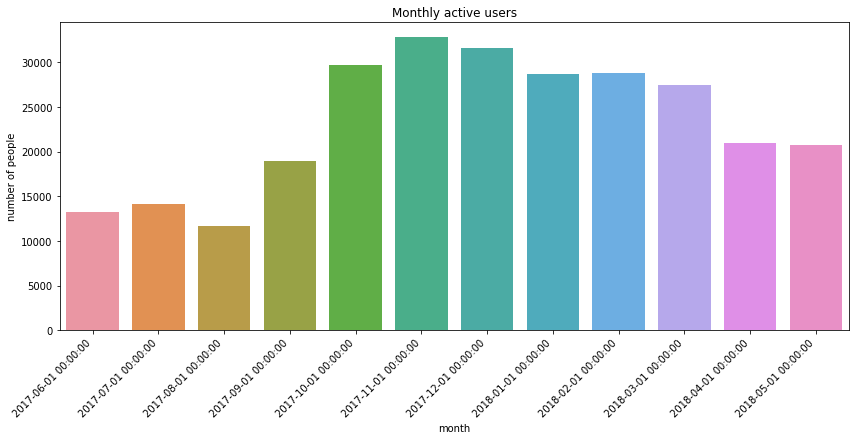

In [19]:

fig, ax = plt.subplots(figsize = (12,6)) 
fig = sns.barplot(data=MAU, x=MAU['month'], y='uid')

ax.set_xticklabels(labels=MAU['month'], rotation=45, ha='right')
plt.tight_layout()
plt.title('Monthly active users')
plt.ylabel('number of people')
plt.show()

In [20]:
WAU = visits.groupby(['week']).agg({'uid':'nunique'}).sort_values('week').reset_index()
display(WAU.head(10))
display(WAU.mean())

,week,uid
0,2017-06-01,4082
1,2017-06-08,3311
2,2017-06-15,2844
3,2017-06-22,3079
4,2017-06-29,3055
5,2017-07-06,3563
6,2017-07-13,4790
7,2017-07-20,2978
8,2017-07-27,2505
9,2017-08-03,2343


uid    5724.415094
dtype: float64

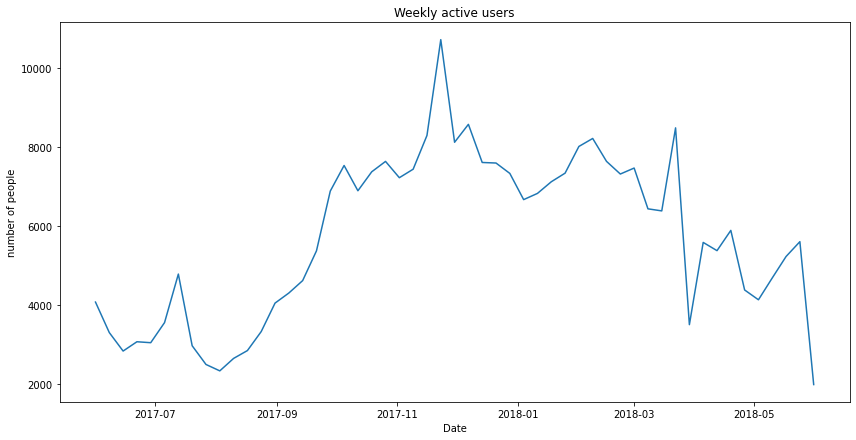

In [21]:
fig, ax = plt.subplots(figsize = (12,6)) 
fig = sns.lineplot(data=WAU, x=WAU['week'], y='uid')


plt.tight_layout()
plt.title('Weekly active users')
plt.ylabel('number of people')
plt.xlabel('Date')
plt.show()

In [22]:
DAU = visits.groupby(visits['day'])['uid'].nunique().reset_index()
display(DAU.sort_values(by='uid',ascending=False))
display(DAU.mean())

,day,uid
176,2017-11-24,3319
363,2018-05-31,1997
177,2017-11-25,1817
245,2018-02-01,1640
298,2018-03-26,1609
...,...,...
73,2017-08-13,281
65,2017-08-05,280
72,2017-08-12,271
302,2018-03-30,131


uid    907.991758
dtype: float64

Text(0.5, 60.0, 'Date')

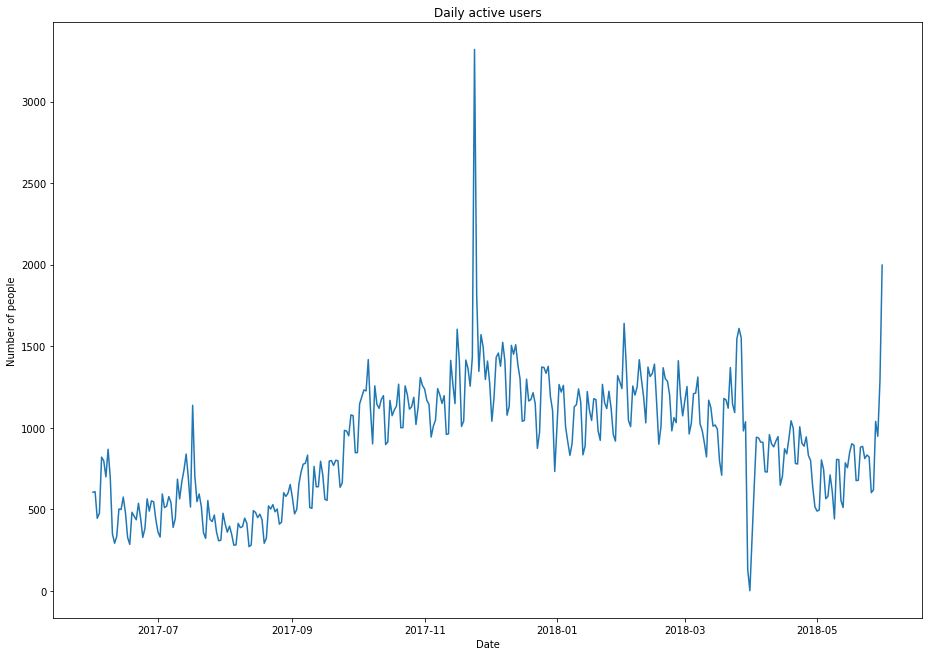

In [23]:
plt.figure(figsize=(13,9))
sns.lineplot(data=DAU, x='day', y='uid')
plt.tight_layout()
plt.title('Daily active users')
plt.ylabel('Number of people')
plt.xlabel('Date')

The analysis of the data provided led to the following conclusions on product usage: on average, 907 people use the product daily, 5621 weekly, and 23228 monthly.
DAU is pretty much stable across the board, with the exception of two peaks and one low: one peak in late November 2017, the second one in late May 2018 and one low in late March 2018.
MAU and WAY dynamics have high correlation, with user activity dropping in bioth during summer months, possibly, owing to summer holiday season.

### How many sessions are there per day? (One user may have more than one session.)

In [24]:
#Calculating sessions per day
sessions = visits.groupby('day').agg({'uid':'count'})
display(sessions.head())
display(sessions.mean())

,uid
day,
2017-06-01,664
2017-06-02,658
2017-06-03,477
2017-06-04,510
2017-06-05,893


uid    987.362637
dtype: float64

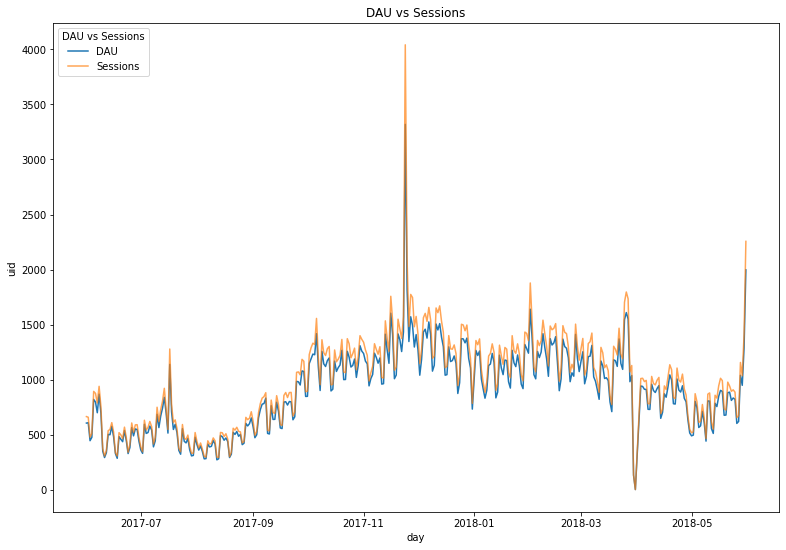

In [25]:
plt.figure(figsize=(13,9))
sns.lineplot(data=DAU, x='day', y='uid')
sns.lineplot(data=sessions, x='day', y='uid', alpha=0.7)
plt.title('DAU vs Sessions')
plt.legend(title='DAU vs Sessions', loc='upper left', labels=['DAU', 'Sessions'])
plt.show()

There are 987 sessions per day on average
As per DAU vs Sessions chart, it can be concluded, that there are almost as many sessions as there are active users per day, which means, in other words, 1 session per user per day.

### What is the length of each session?

In [26]:
visits['session_length'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
print(f'The median of the session length is: {visits.session_length.median()}')
print(f'The mode of the session length is: {visits.session_length.mode()}')


The median of the session length is: 300.0
The mode of the session length is: 0    60
dtype: int64


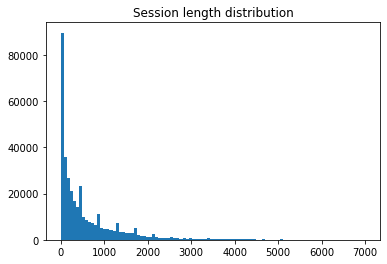

In [27]:
#Session length distribution
visits['session_length'].describe()
x=visits['session_length']
plt.hist(x,bins=100, range=(0,7000))
plt.title('Session length distribution')
plt.show()

Since the distribution is skewed to the right, it is more sensible to use the most common value (mode) to get the sense of the length of each session. It turns out, that the most common session duration is 1 min.

### What's the user retention rate?


In [28]:
# First, let's find the month when the first session took place
min_visit= visits.groupby('uid')['start_ts'].min().reset_index()
min_visit.columns = ['uid', 'first_session']
min_visit

,uid,first_session
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00
...,...,...
228164,18446403737806311543,2017-11-30 03:36:00
228165,18446424184725333426,2017-12-06 20:32:00
228166,18446556406699109058,2018-01-01 16:29:00
228167,18446621818809592527,2017-12-27 13:27:00


In [29]:
# Let's merge the first session with the visits table

visits = visits.merge(min_visit, how = 'left', on=['uid'])
visits['first_session_month'] = visits['first_session'].astype('datetime64[M]')
visits.tail()

,device,end_ts,source_id,start_ts,uid,year,month,week,day,session_length,first_session,first_session_month
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-01-01,2017-07-01,2017-07-27,2017-07-29,19,2017-07-29 19:07:00,2017-07-01
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-01,2018-01-01,2018-01-25,2018-01-25,19,2018-01-25 17:38:00,2018-01-01
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-01-01,2018-03-01,2018-03-01,2018-03-03,19,2018-03-03 10:12:00,2018-03-01
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-01-01,2017-11-01,2017-11-02,2017-11-02,19,2017-11-02 10:12:00,2017-11-01
359399,touch,2017-09-10 13:13:19,2,2017-09-10 13:13:00,18396128934054549559,2017-01-01,2017-09-01,2017-09-07,2017-09-10,19,2017-09-10 13:13:00,2017-09-01


In [30]:
# Now let's create a column with cohorts lifetime

visits['first_activity_month']= visits['first_session'].astype('datetime64[M]')
visits['cohort_lifetime']= ((pd.to_datetime(visits['month']) - pd.to_datetime(visits['first_session_month']))/ np.timedelta64(1,'M')).round().astype(int)
visits.head()








,device,end_ts,source_id,start_ts,uid,year,month,week,day,session_length,first_session,first_session_month,first_activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09 20:05:00,2018-03-01,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,2017-12-21,2017-12-27,0,2017-12-27 14:06:00,2017-12-01,2017-12-01,0


In [31]:
# Building cohort table

cohorts = visits.pivot_table(index='first_activity_month', columns='cohort_lifetime', values='uid', aggfunc='nunique')
cohorts

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,13259.0,1043.0,713.0,814.0,909.0,947.0,809.0,766.0,694.0,674.0,539.0,596.0
2017-07-01,13140.0,737.0,674.0,738.0,765.0,633.0,596.0,601.0,510.0,376.0,361.0,NaN
2017-08-01,10181.0,783.0,640.0,639.0,510.0,448.0,370.0,402.0,284.0,265.0,NaN,NaN
2017-09-01,16704.0,1428.0,1156.0,847.0,658.0,632.0,599.0,404.0,381.0,NaN,NaN,NaN
2017-10-01,25977.0,2042.0,1357.0,1012.0,890.0,837.0,555.0,529.0,NaN,NaN,NaN,NaN
2017-11-01,27248.0,2133.0,1202.0,1054.0,919.0,638.0,594.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,25268.0,1410.0,960.0,786.0,512.0,481.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,22624.0,1351.0,890.0,565.0,458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,22197.0,1267.0,565.0,446.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Building a retention rate table
retention = cohorts.iloc[:,0:].div(cohorts[0], axis=0)
retention

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


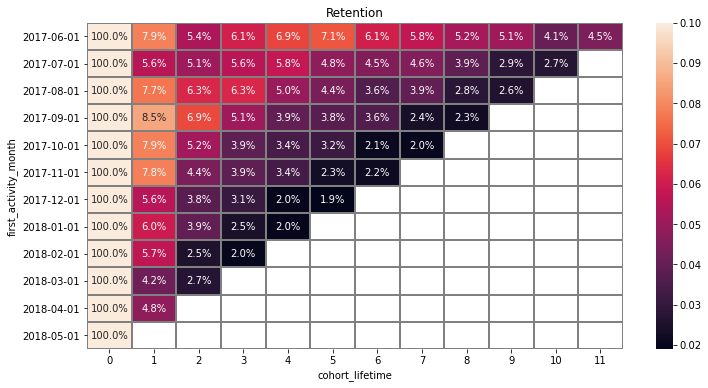

In [33]:
plt.figure(figsize=(12,6))
retention.index=retention.index.astype(str)
sns.heatmap(retention, annot=True, fmt='.1%', linewidths=1, linecolor='grey',  vmax=0.1)
plt.title('Retention')
plt.show()

The June cohort is overall the most successful, it has the highest retention rates in the majority of months, except for second and third, when compared to other cohorts. 

The September cohort can be regarded as the second most successful, with the highest first (8.5%) and second (6.9%) month of all cohorts.

Also, it is worthy of noting, that with the advent of winter, retention drops significantly starting from the first month to around 5-6%, which could be attributed to harsh weather conditions that keep people inside.

## Sales

### When do people start buying? 

In order to answer this question it's necessary to establish the time when the first purchase took place and then subtract first_session from it. 

In [34]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [35]:
first_purchase = orders.groupby(['uid'])['buy_ts'].min().reset_index()

first_purchase.columns = ['uid','first_purchase']
first_purchase.head()

,uid,first_purchase
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


**Let's merge first_purchase and orders to get a table that is going to be used in further calculations**

In [36]:
orders_new = first_purchase.merge(orders, on='uid')
orders_new

,uid,first_purchase,buy_ts,revenue
0,313578113262317,2018-01-03 21:51:00,2018-01-03 21:51:00,0.55
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,1.22
2,1575281904278712,2017-06-03 10:13:00,2017-06-03 17:39:00,1.83
3,2429014661409475,2017-10-11 18:33:00,2017-10-11 18:33:00,73.33
4,2464366381792757,2018-01-28 15:54:00,2018-01-28 15:54:00,2.44
...,...,...,...,...
50410,18445407535914413204,2017-09-22 23:55:00,2017-09-24 23:48:00,0.24
50411,18445407535914413204,2017-09-22 23:55:00,2017-09-25 15:56:00,0.12
50412,18445601152732270159,2018-03-26 22:54:00,2018-03-26 22:54:00,4.22
50413,18446156210226471712,2018-02-18 19:34:00,2018-02-18 19:34:00,9.78


In [37]:
#Adding a first_purchase column to the dataset
visits = visits.merge(orders_new, how='left', on='uid')
display(visits.tail())

,device,end_ts,source_id,start_ts,uid,year,month,week,day,session_length,first_session,first_session_month,first_activity_month,cohort_lifetime,first_purchase
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-01-01,2017-07-01,2017-07-27,2017-07-29,19,2017-07-29 19:07:00,2017-07-01,2017-07-01,0,2017-07-29 19:07:00
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-01,2018-01-01,2018-01-25,2018-01-25,19,2018-01-25 17:38:00,2018-01-01,2018-01-01,0,2018-01-25 17:38:00
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-01-01,2018-03-01,2018-03-01,2018-03-03,19,2018-03-03 10:12:00,2018-03-01,2018-03-01,0,2018-03-03 10:12:00
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-01-01,2017-11-01,2017-11-02,2017-11-02,19,2017-11-02 10:12:00,2017-11-01,2017-11-01,0,2017-11-02 10:12:00
359399,touch,2017-09-10 13:13:19,2,2017-09-10 13:13:00,18396128934054549559,2017-01-01,2017-09-01,2017-09-07,2017-09-10,19,2017-09-10 13:13:00,2017-09-01,2017-09-01,0,2017-09-10 13:13:00


In [59]:
#Filtering visits dataset from entries without a sale
purchase = visits.query('first_purchase!= "NaT"')
purchase = pd.DataFrame(purchase)

In [60]:
display(purchase.head())

,device,end_ts,source_id,start_ts,uid,year,month,week,day,session_length,first_session,first_session_month,first_activity_month,cohort_lifetime,first_purchase
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09 20:05:00,2018-03-01,2018-03-01,2,2018-03-09 20:25:00
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-01-01,2017-09-01,2017-08-31,2017-09-03,60,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-09-04 12:46:00
12,desktop,2018-02-06 15:50:00,4,2018-02-06 15:45:00,8056418121947262981,2018-01-01,2018-02-01,2018-02-01,2018-02-06,300,2017-06-04 14:17:00,2017-06-01,2017-06-01,8,2017-06-25 08:54:00
15,touch,2018-02-12 20:30:00,2,2018-02-12 19:24:00,18188358787673499603,2018-01-01,2018-02-01,2018-02-08,2018-02-12,3960,2018-02-10 12:17:00,2018-02-01,2018-02-01,0,2018-02-12 19:48:00
25,desktop,2017-12-05 10:28:00,4,2017-12-05 10:21:00,2307401184189569202,2017-01-01,2017-12-01,2017-11-30,2017-12-05,420,2017-09-23 23:27:00,2017-09-01,2017-09-01,3,2017-09-27 09:23:00


**Let's calculate conversion time in days and plot it on histogram**

In [77]:


purchase['conversion_in_days'] = ((pd.to_datetime(purchase['first_purchase']) - pd.to_datetime(purchase['first_session'])) / np.timedelta64(1, 'D')).astype('int')

#purchase['conversion_in_days'] = purchase['conversion_in_days']/ np.timedelta64(1,'D')
#purchase['conversion_in_days'] = purchase['conversion_in_days'].round().astype('int')
display(purchase.head(10))



,device,end_ts,source_id,start_ts,uid,year,month,week,day,session_length,first_session,first_session_month,first_activity_month,cohort_lifetime,first_purchase,conversion_in_days
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09 20:05:00,2018-03-01,2018-03-01,2,2018-03-09 20:25:00,0
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-01-01,2017-09-01,2017-08-31,2017-09-03,60,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-09-04 12:46:00,0
12,desktop,2018-02-06 15:50:00,4,2018-02-06 15:45:00,8056418121947262981,2018-01-01,2018-02-01,2018-02-01,2018-02-06,300,2017-06-04 14:17:00,2017-06-01,2017-06-01,8,2017-06-25 08:54:00,20
15,touch,2018-02-12 20:30:00,2,2018-02-12 19:24:00,18188358787673499603,2018-01-01,2018-02-01,2018-02-08,2018-02-12,3960,2018-02-10 12:17:00,2018-02-01,2018-02-01,0,2018-02-12 19:48:00,2
25,desktop,2017-12-05 10:28:00,4,2017-12-05 10:21:00,2307401184189569202,2017-01-01,2017-12-01,2017-11-30,2017-12-05,420,2017-09-23 23:27:00,2017-09-01,2017-09-01,3,2017-09-27 09:23:00,3
27,desktop,2017-10-23 12:58:00,3,2017-10-23 12:49:00,4499746016005494365,2017-01-01,2017-10-01,2017-10-19,2017-10-23,540,2017-10-23 12:49:00,2017-10-01,2017-10-01,0,2017-11-16 14:04:00,24
37,desktop,2018-03-12 23:25:00,3,2018-03-12 23:13:00,15857957287537270437,2018-01-01,2018-03-01,2018-03-08,2018-03-12,720,2017-09-22 21:16:00,2017-09-01,2017-09-01,6,2018-03-12 23:17:00,171
38,touch,2018-03-01 08:45:00,4,2018-03-01 08:43:00,15763368622958393183,2018-01-01,2018-03-01,2018-03-01,2018-03-01,120,2017-11-06 09:52:00,2017-11-01,2017-11-01,4,2018-03-06 18:33:00,120
43,touch,2018-03-27 17:52:00,5,2018-03-27 17:32:00,15868686231870595097,2018-01-01,2018-03-01,2018-03-22,2018-03-27,1200,2018-03-27 16:18:00,2018-03-01,2018-03-01,0,2018-03-27 19:45:00,0
44,desktop,2017-12-26 14:39:00,9,2017-12-26 14:00:00,9419370217043167984,2017-01-01,2017-12-01,2017-12-21,2017-12-26,2340,2017-09-14 10:31:00,2017-09-01,2017-09-01,3,2017-10-03 11:02:00,19


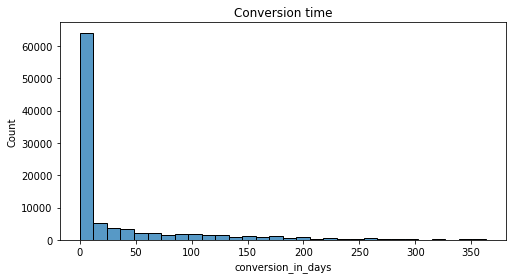

In [80]:
#Let's see what the conversion time looks like
plt.figure(figsize=(8,4))
sns.histplot(data=purchase,x='conversion_in_days', bins=30)
#plt.xlim(0,200)
plt.title('Conversion time')
plt.show()

In [81]:
print(f'The median conversion time, in days, is: {purchase.conversion_in_days.median()}')

The median conversion time, in days, is: 1.0


**It takes 1 day, on average, for a user to make a purchase. It is interesting to know, how many users made a purchase relative to total users?**

In [82]:
#The conversion rate of all users
conversion_rate =   purchase['uid'].nunique() / visits['uid'].nunique()
print(f"The conversion rate to purchase is: {conversion_rate:.1%}" )




The conversion rate to purchase is: 16.0%


### How many orders do users make during a given period of time?


In [42]:
#Creating a new first_purchase_month and purchase_month column to be able to calculate a cohort_size and cohorts tables by each month 
orders_new['first_purchase_month'] = orders_new['first_purchase'].astype('datetime64[M]')
orders_new['purchase_month'] = orders_new['buy_ts'].astype('datetime64[M]')
orders_new

,uid,first_purchase,buy_ts,revenue,conversion_in_days,first_purchase_month,purchase_month
0,313578113262317,2018-01-03 21:51:00,2018-01-03 21:51:00,0.55,0,2018-01-01,2018-01-01
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,1.22,0,2017-06-01,2017-06-01
2,1575281904278712,2017-06-03 10:13:00,2017-06-03 17:39:00,1.83,0,2017-06-01,2017-06-01
3,2429014661409475,2017-10-11 18:33:00,2017-10-11 18:33:00,73.33,0,2017-10-01,2017-10-01
4,2464366381792757,2018-01-28 15:54:00,2018-01-28 15:54:00,2.44,0,2018-01-01,2018-01-01
...,...,...,...,...,...,...,...
50410,18445407535914413204,2017-09-22 23:55:00,2017-09-24 23:48:00,0.24,2,2017-09-01,2017-09-01
50411,18445407535914413204,2017-09-22 23:55:00,2017-09-25 15:56:00,0.12,3,2017-09-01,2017-09-01
50412,18445601152732270159,2018-03-26 22:54:00,2018-03-26 22:54:00,4.22,0,2018-03-01,2018-03-01
50413,18446156210226471712,2018-02-18 19:34:00,2018-02-18 19:34:00,9.78,0,2018-02-01,2018-02-01


In [43]:
purchase_cohort = orders_new.groupby('first_purchase_month').agg({'uid':'nunique'}).reset_index()
purchase_cohort.columns=['first_purchase_month','cohort_size']
purchase_cohort

,first_purchase_month,cohort_size
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [44]:
#calculating the number of purchases for cohort and month
cohorts = orders_new.groupby(['first_purchase_month', 'purchase_month']).agg({'uid':'count'}).reset_index()
cohorts.columns = ['first_purchase_month','purchase_month','orders']
cohorts


,first_purchase_month,purchase_month,orders
0,2017-06-01,2017-06-01,2354
1,2017-06-01,2017-07-01,177
2,2017-06-01,2017-08-01,174
3,2017-06-01,2017-09-01,226
4,2017-06-01,2017-10-01,292
...,...,...,...
74,2018-03-01,2018-05-01,176
75,2018-04-01,2018-04-01,2495
76,2018-04-01,2018-05-01,195
77,2018-05-01,2018-05-01,3249


In [45]:
#merging with purchase_cohort (the table with the number of unique paying users)
cohorts = cohorts.merge(purchase_cohort, how='inner', on= 'first_purchase_month')

cohorts['age']= ((pd.to_datetime(cohorts['purchase_month'])-pd.to_datetime(cohorts['first_purchase_month']))
                 /np.timedelta64(1,'M')).round()
cohorts

,first_purchase_month,purchase_month,orders,cohort_size,age
0,2017-06-01,2017-06-01,2354,2023,0.0
1,2017-06-01,2017-07-01,177,2023,1.0
2,2017-06-01,2017-08-01,174,2023,2.0
3,2017-06-01,2017-09-01,226,2023,3.0
4,2017-06-01,2017-10-01,292,2023,4.0
...,...,...,...,...,...
74,2018-03-01,2018-05-01,176,3533,2.0
75,2018-04-01,2018-04-01,2495,2276,0.0
76,2018-04-01,2018-05-01,195,2276,1.0
77,2018-05-01,2018-05-01,3249,2988,0.0


In [46]:
cohorts['orders_per_buyer'] = cohorts['orders']/cohorts['cohort_size']
cohorts.head()

,first_purchase_month,purchase_month,orders,cohort_size,age,orders_per_buyer
0,2017-06-01,2017-06-01,2354,2023,0.0,1.163618
1,2017-06-01,2017-07-01,177,2023,1.0,0.087494
2,2017-06-01,2017-08-01,174,2023,2.0,0.086011
3,2017-06-01,2017-09-01,226,2023,3.0,0.111715
4,2017-06-01,2017-10-01,292,2023,4.0,0.144340


In [47]:
cohorts.pivot = cohorts.pivot_table(index='first_purchase_month', columns='age', values='orders_per_buyer',aggfunc='sum')
cohorts.pivot.round(2).fillna('')

age,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_purchase_month,,,,,,,,,,,,
2017-06-01,1.16,0.09,0.09,0.11,0.14,0.11,0.14,0.09,0.1,0.08,0.05,0.04
2017-07-01,1.14,0.05,0.06,0.05,0.04,0.04,0.03,0.03,0.03,0.01,0.03,
2017-08-01,1.12,0.08,0.07,0.06,0.06,0.05,0.04,0.06,0.03,0.03,,
2017-09-01,1.14,0.08,0.06,0.06,0.03,0.04,0.04,0.02,0.02,,,
2017-10-01,1.14,0.07,0.04,0.03,0.03,0.02,0.02,0.03,,,,
2017-11-01,1.18,0.1,0.04,0.05,0.03,0.01,0.02,,,,,
2017-12-01,1.15,0.06,0.05,0.04,0.02,0.02,,,,,,
2018-01-01,1.12,0.07,0.05,0.02,0.02,,,,,,,
2018-02-01,1.12,0.06,0.02,0.02,,,,,,,,


In [48]:
#In this pivot table cumulative sum is implemented to be able to see which cohort performed better in the long run
cohorts.pivot = cohorts.pivot_table(index='first_purchase_month', columns='age', values='orders_per_buyer',aggfunc='sum').cumsum(axis=1)
cohorts.pivot.round(2).fillna('')


age,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_purchase_month,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.7,1.84,1.92,2.03,2.1,2.15,2.19
2017-07-01,1.14,1.19,1.25,1.31,1.34,1.39,1.42,1.44,1.47,1.49,1.51,
2017-08-01,1.12,1.2,1.27,1.33,1.39,1.44,1.47,1.53,1.56,1.6,,
2017-09-01,1.14,1.22,1.28,1.35,1.37,1.42,1.46,1.48,1.5,,,
2017-10-01,1.14,1.22,1.25,1.28,1.31,1.34,1.35,1.38,,,,
2017-11-01,1.18,1.28,1.32,1.37,1.41,1.42,1.45,,,,,
2017-12-01,1.15,1.21,1.26,1.3,1.32,1.34,,,,,,
2018-01-01,1.12,1.19,1.24,1.25,1.28,,,,,,,
2018-02-01,1.12,1.18,1.21,1.22,,,,,,,,


**June cohort has the largest orders per buyer in total of all cohorts with 2.19 orders, followed by the August cohort, with 1.6 orders.**

### What is the average purchase size?

In [49]:
#Calculating the overall average cheque 
revenue = orders_new.groupby('uid')['revenue'].sum().reset_index()
revenue.columns = ['uid', 'revenue']
display(revenue['revenue'].describe())
display(f'The average purchase size is: {revenue.revenue.median()}')

count    36523.000000
mean         6.901328
std         88.128535
min          0.000000
25%          1.470000
50%          3.050000
75%          5.800000
max      11810.180000
Name: revenue, dtype: float64

'The average purchase size is: 3.05'

In [50]:
# To calculate average cheque by each month and cohort we can create a pivot table using the orders_new table
avg = orders_new.groupby(['first_purchase_month', 'purchase_month']).agg({'revenue':'mean'}).reset_index()
avg.columns = ['first_purchase_month','purchase_month','revenue']
avg['age']= ((pd.to_datetime(avg['purchase_month'])-pd.to_datetime(avg['first_purchase_month']))
                 /np.timedelta64(1,'M')).round() 
avg_pivot = avg.pivot_table(index='first_purchase_month', columns = 'age', values = 'revenue', aggfunc='mean').round(2)

avg_pivot.fillna('')

age,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_purchase_month,,,,,,,,,,,,
2017-06-01,4.06,5.55,5.09,8.55,7.08,6.83,6.97,6.76,5.28,8.01,12.04,6.04
2017-07-01,5.29,6.45,9.99,6.64,4.72,3.66,3.79,5.45,5.35,11.79,5.65,
2017-08-01,4.72,5.99,6.28,6.62,7.96,6.27,5.89,7.11,8.7,5.6,,
2017-09-01,4.97,13.17,8.35,62.57,15.43,15.32,16.77,11.21,7.79,,,
2017-10-01,4.37,7.41,5.13,5.59,5.1,5.07,4.28,4.01,,,,
2017-11-01,4.37,4.1,4.47,6.28,4.44,3.73,4.6,,,,,
2017-12-01,4.11,4.23,20.07,26.08,15.95,14.11,,,,,,
2018-01-01,3.69,4.44,6.45,7.52,2.71,,,,,,,
2018-02-01,3.71,4.58,3.45,3.87,,,,,,,,


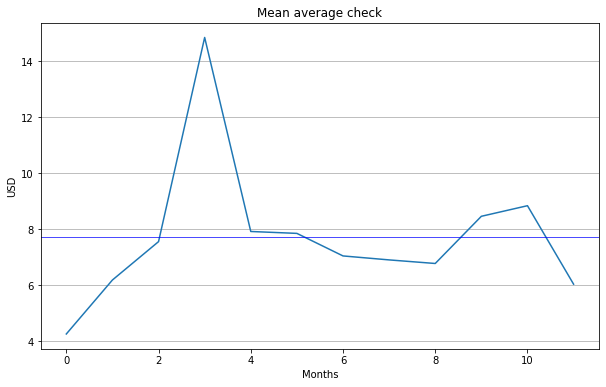

In [51]:
# Creating a DataFrame with mean average cheque values only
avg_pivot_mean = avg_pivot.mean(numeric_only=True, skipna=True, axis=0)
# Plotting a linechart describing  mean average cheque values over time 
fig, ax = plt.subplots(figsize = (10,6))
ax.grid(axis ='y')
ax.plot(avg_pivot_mean)
# Finding out a mean value from the avg cheque pivot table to plot a horizontal line
hline_mean=avg_pivot_mean.mean()

ax.set_xlabel('Months')
ax.set_ylabel('USD')
ax.set_title('Mean average check')
ax.axhline(y=hline_mean, linewidth=1, color = 'blue', alpha = 0.7)

plt.show()

In [52]:
avg_pivot.mean(numeric_only=True, skipna=True, axis=1)

first_purchase_month
2017-06-01     6.855000
2017-07-01     6.252727
2017-08-01     6.514000
2017-09-01    17.286667
2017-10-01     5.120000
2017-11-01     4.570000
2017-12-01    14.091667
2018-01-01     4.962000
2018-02-01     3.902500
2018-03-01     5.480000
2018-04-01     5.225000
2018-05-01     4.290000
2018-06-01     3.420000
dtype: float64

**The average cheque is stable around the whole record history, with the exception of the September cohort, averaging 17 usd and December cohort with 14 usd mean value.**

### How much money do they bring?

LTV - a perfect metric, that could answer this question. Let's calculate it.

In [53]:
ltv_cohorts = orders_new.groupby(['first_purchase_month', 'purchase_month']).agg({'revenue':'sum'}).reset_index()
ltv_cohorts.columns = ['first_purchase_month','purchase_month','revenue']
ltv_cohorts

,first_purchase_month,purchase_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58
...,...,...,...
74,2018-03-01,2018-05-01,1114.87
75,2018-04-01,2018-04-01,10600.69
76,2018-04-01,2018-05-01,1209.92
77,2018-05-01,2018-05-01,13925.76


In [54]:
ltv_cohorts = ltv_cohorts.merge(purchase_cohort, on='first_purchase_month')

In [55]:
ltv_cohorts['age'] = ((pd.to_datetime(ltv_cohorts['purchase_month'])-pd.to_datetime(ltv_cohorts['first_purchase_month']))
                 /np.timedelta64(1,'M')).round()  
ltv_cohorts['ltv'] = ltv_cohorts['revenue']/ltv_cohorts['cohort_size']
ltv_cohorts

,first_purchase_month,purchase_month,revenue,cohort_size,age,ltv
0,2017-06-01,2017-06-01,9557.49,2023,0.0,4.724414
1,2017-06-01,2017-07-01,981.82,2023,1.0,0.485329
2,2017-06-01,2017-08-01,885.34,2023,2.0,0.437637
3,2017-06-01,2017-09-01,1931.30,2023,3.0,0.954671
4,2017-06-01,2017-10-01,2068.58,2023,4.0,1.022531
...,...,...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,3533,2.0,0.315559
75,2018-04-01,2018-04-01,10600.69,2276,0.0,4.657597
76,2018-04-01,2018-05-01,1209.92,2276,1.0,0.531599
77,2018-05-01,2018-05-01,13925.76,2988,0.0,4.660562


In [56]:
#Building a cohort table to see how LTV metric looks like in different cohorts. 
#Cumulative sum will be used here to make it easier to distinguish better performing cohorts.
ltv_pivot = ltv_cohorts.pivot_table(index= 'first_purchase_month', columns = 'age', values = 'ltv', aggfunc = 'sum').cumsum(axis=1)
ltv_pivot

age,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_purchase_month,,,,,,,,,,,,
2017-06-01,4.724414,5.209743,5.647380,6.602051,7.624582,8.360084,9.310524,9.892116,10.445329,11.051117,11.622378,11.879234
2017-07-01,6.010218,6.345429,6.968960,7.327936,7.504727,7.660775,7.780983,7.922803,8.084035,8.231180,8.386854,NaN
2017-08-01,5.276518,5.748511,6.206993,6.598270,7.092321,7.375861,7.586526,7.991533,8.283745,8.471723,NaN,NaN
2017-09-01,5.644529,6.762115,7.283045,11.258838,11.659396,12.306463,13.008071,13.251220,13.435227,NaN,NaN,NaN
2017-10-01,5.003733,5.539495,5.730889,5.888035,6.039594,6.159956,6.244772,6.360242,NaN,NaN,NaN,NaN
2017-11-01,5.154683,5.553916,5.753472,6.078424,6.226437,6.280316,6.395244,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738191,4.998565,5.923662,6.988937,7.301866,7.639913,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.135636,4.430394,4.734675,4.877453,4.940151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.156987,4.435262,4.513777,4.587921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


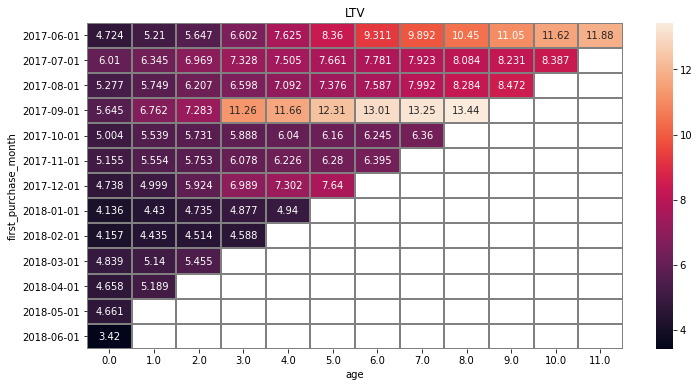

In [57]:

plt.figure(figsize=(12,6))
ltv_pivot.index=ltv_pivot.index.astype(str)
ltv_pivot_heatmap = sns.heatmap(ltv_pivot, annot=True, fmt='.4', linewidths=1, linecolor='grey').set(title='LTV')
plt.show()

**It can be derived from the pivot_table, that there are two cohorts that performed better, than others on 6 months mark, namely June and Semtember cohorts. The June cohort saw 11.88 usd ltv per user and September cohort saw 13.44 usd ltv per user.**

## Marketing

### How much money was spent? Overall, per source and over time

In [58]:
#Overall costs
costs['costs'].sum()

329131.62

**Overall, 329131.62 usd was spent on marketing**

In [59]:
#Costs per source
costs.groupby('source_id').agg({'costs':'sum'})

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


Let's calculate CAC (Customer Acquisition Cost)

In [60]:
#Costs over time
costs_by_month = costs['month'] = costs['dt'].astype('datetime64[M]')
costs_by_month = costs.groupby(['month'])['costs'].sum().reset_index()
costs_by_month

,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


In [61]:
buyers = orders_new.groupby('first_purchase_month')['uid'].nunique().reset_index()
buyers.columns = ['month','buyers']
buyers

,month,buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [62]:
CAC_by_month = costs_by_month.merge(buyers, on='month')
CAC_by_month['CAC'] = CAC_by_month['costs'] / CAC_by_month['buyers'] 
CAC_by_month

,month,costs,buyers,CAC
0,2017-06-01,18015.00,2023,8.905091
1,2017-07-01,18240.59,1923,9.485486
2,2017-08-01,14790.54,1370,10.796015
3,2017-09-01,24368.91,2581,9.441654
4,2017-10-01,36322.88,4340,8.369327
5,2017-11-01,37907.88,4081,9.288870
6,2017-12-01,38315.35,4383,8.741809
7,2018-01-01,33518.52,3373,9.937302
8,2018-02-01,32723.03,3651,8.962758
9,2018-03-01,30415.27,3533,8.608907


In [63]:
CAC_by_month['buyers'].median()

3180.5

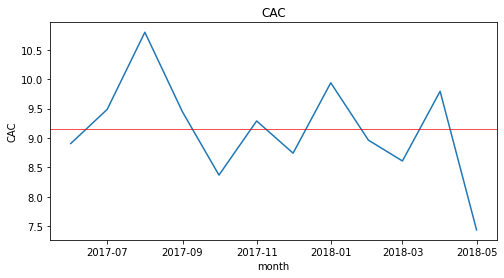

In [64]:
# Let's see what CAC looks like in time
plt.figure(figsize=(8,4))
sns.lineplot(data=CAC_by_month,x='month', y='CAC').set(title='CAC')
CAC_mean = CAC_by_month.CAC.mean()
plt.axhline(y=CAC_mean, linewidth=1, color = 'red', alpha = 0.7)
plt.show() 


We can derive following conclusions from the chart above:
1. CAC is relatively stable across the timeline, with one major exception - august 2018. That month saw the fewest acquired users of all (1370), which led to record high CAC (10.8 USD), since the costs were not aligned accordingly. 
2. The most cost effective month of all was May 2018 with just 7.4 USD CAC and respectable, slightly below average acquired user number of 2988.

### How much did customer acquisition from each of the sources cost?

**Let's caluculate the cost of acquisition (CAC) by each source**

In [65]:
#First, primary acquisition source per user has to be found

user_source = visits.sort_values(['start_ts']).groupby('uid')['source_id'].first().reset_index()
user_source


,uid,source_id
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5
...,...,...
228164,18446403737806311543,5
228165,18446424184725333426,4
228166,18446556406699109058,3
228167,18446621818809592527,4


In [66]:
#Second, a source column is added to orders_new table 

orders_source = user_source.merge(orders_new, on='uid')
orders_source.head()


,uid,source_id,first_purchase,buy_ts,revenue,conversion_in_days,first_purchase_month,purchase_month
0,313578113262317,2,2018-01-03 21:51:00,2018-01-03 21:51:00,0.55,0,2018-01-01,2018-01-01
1,1575281904278712,10,2017-06-03 10:13:00,2017-06-03 10:13:00,1.22,0,2017-06-01,2017-06-01
2,1575281904278712,10,2017-06-03 10:13:00,2017-06-03 17:39:00,1.83,0,2017-06-01,2017-06-01
3,2429014661409475,3,2017-10-11 18:33:00,2017-10-11 18:33:00,73.33,0,2017-10-01,2017-10-01
4,2464366381792757,5,2018-01-28 15:54:00,2018-01-28 15:54:00,2.44,0,2018-01-01,2018-01-01


In [67]:
#Third, table is grouped to find out the number of unique users by their source 
orders_source = orders_source.groupby([ 'source_id'])['uid'].nunique().reset_index()
orders_source.columns = ['source_id', 'num_buyers']
orders_source

,source_id,num_buyers
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


In [68]:
cost_by_source = costs.groupby(['source_id'])['costs'].sum().reset_index()
cost_by_source.columns= ['source_id', 'costs']
cost_by_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [69]:
CAC_by_source = cost_by_source.merge(
    orders_source, left_on = ['source_id'], right_on = [ 'source_id'])
CAC_by_source['cac_source']= CAC_by_source['costs'] / CAC_by_source['num_buyers']
CAC_by_source

,source_id,costs,num_buyers,cac_source
0,1,20833.27,2899,7.186364
1,2,42806.04,3506,12.209367
2,3,141321.63,10473,13.493901
3,4,61073.60,10296,5.931779
4,5,51757.10,6931,7.467479
5,9,5517.49,1088,5.071222
6,10,5822.49,1329,4.381106


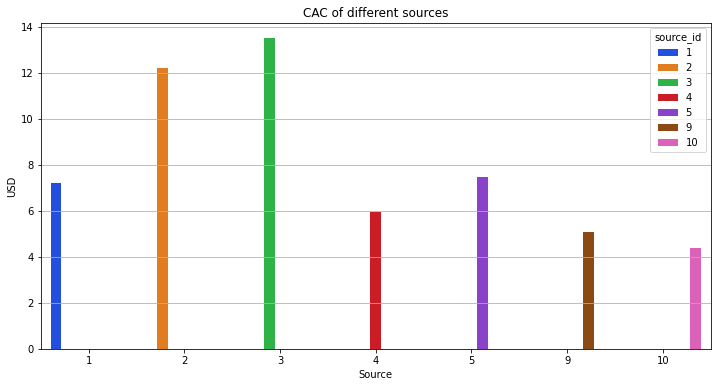

In [70]:
#Plotting the linechart to see CAC in time by source
plt.figure(figsize = (12,6))
ax = sns.barplot(data=CAC_by_source, x='source_id', y='cac_source', palette='bright',
                  hue = 'source_id')
ax.grid(axis='y')

#Plotting additional info
ax.set_title('CAC of different sources')
ax.set_xlabel('Source')
ax.set_ylabel('USD')
plt.show()

**It can be concluded, that, on average, the most expensive sources of acquisition are 2,3, while 10, 9 are the most cost effective sources**

### How worthwhile where the investments? (ROI)

The formula that is used to calculate ROI is as follows: ROI = LTV/CAC
First, we shall find out ROI in general and then by source.

In [71]:
#Creating a CAC table that is going to be merged with LTV table
CAC_by_month_ROI=CAC_by_month[['month','CAC']]
CAC_by_month_ROI.columns=['first_purchase_month','CAC']
CAC_by_month_ROI


,first_purchase_month,CAC
0,2017-06-01,8.905091
1,2017-07-01,9.485486
2,2017-08-01,10.796015
3,2017-09-01,9.441654
4,2017-10-01,8.369327
5,2017-11-01,9.288870
6,2017-12-01,8.741809
7,2018-01-01,9.937302
8,2018-02-01,8.962758
9,2018-03-01,8.608907


In [72]:
ROI=ltv_cohorts.merge(CAC_by_month_ROI,on=['first_purchase_month'],how='left')
ROI.head()

,first_purchase_month,purchase_month,revenue,cohort_size,age,ltv,CAC
0,2017-06-01,2017-06-01,9557.49,2023,0.0,4.724414,8.905091
1,2017-06-01,2017-07-01,981.82,2023,1.0,0.485329,8.905091
2,2017-06-01,2017-08-01,885.34,2023,2.0,0.437637,8.905091
3,2017-06-01,2017-09-01,1931.30,2023,3.0,0.954671,8.905091
4,2017-06-01,2017-10-01,2068.58,2023,4.0,1.022531,8.905091


In [73]:
#Adding a ROI column in the ROI table to be used further in creating a pivot_table
ROI['ROI']=ROI['ltv']/ROI['CAC']
ROI.head()

,first_purchase_month,purchase_month,revenue,cohort_size,age,ltv,CAC,ROI
0,2017-06-01,2017-06-01,9557.49,2023,0.0,4.724414,8.905091,0.530530
1,2017-06-01,2017-07-01,981.82,2023,1.0,0.485329,8.905091,0.054500
2,2017-06-01,2017-08-01,885.34,2023,2.0,0.437637,8.905091,0.049145
3,2017-06-01,2017-09-01,1931.30,2023,3.0,0.954671,8.905091,0.107205
4,2017-06-01,2017-10-01,2068.58,2023,4.0,1.022531,8.905091,0.114825


In [74]:
#Creating a pivot table describing return on investment by cohort
ROI_piv = ROI.pivot_table(
    index='first_purchase_month', columns='age', values='ROI', aggfunc='mean').cumsum(axis=1).round(2)
ROI_piv

age,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_purchase_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,NaN
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,NaN,NaN
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.40,1.42,NaN,NaN,NaN
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,NaN,NaN,NaN,NaN
2017-11-01,0.55,0.60,0.62,0.65,0.67,0.68,0.69,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.87,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.46,0.49,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


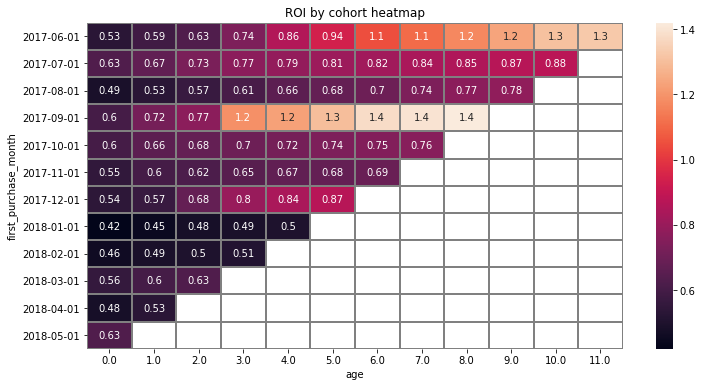

In [75]:
plt.figure(figsize=(12,6))
ROI_piv.index=ROI_piv.index.astype(str)
sns.heatmap(ROI_piv, annot=True, fmt='.2', linewidths=1, linecolor='grey').set(title='ROI by cohort heatmap')
plt.show()

Generally, the investments in marketing don't break even with few notable exceptions. June cohort features poor return in the first half of the year and only manages to start returning the money invested only on the 7th month, while the Semptember cohort comes on top with reaching the break evem point and exceeding it on thr 4th month. 

Now let's find ROI per source_id

In [76]:
costs['month'] = costs['dt'].astype('datetime64[M]')

costs_source = costs.groupby(['source_id' ])['costs'].sum().reset_index()
costs_source




,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [77]:
orders_source1 =  user_source.merge(orders_new, on='uid')
orders_source1 = orders_source1.groupby('source_id').agg({'uid':'nunique','revenue':'sum'}).reset_index()
orders_source1.columns = ['source_id', 'num_buyers', 'revenue']
orders_source1

,source_id,num_buyers,revenue
0,1,2899,31090.55
1,2,3506,46923.61
2,3,10473,54511.24
3,4,10296,56696.83
4,5,6931,52624.02
5,7,1,1.22
6,9,1088,5759.40
7,10,1329,4450.33


In [78]:
ROI_by_source = orders_source1.merge(costs_source, on='source_id')
ROI_by_source['ltv_source'] = ROI_by_source['revenue'] / ROI_by_source['num_buyers']
ROI_by_source['cac_source'] = ROI_by_source['costs'] / ROI_by_source['num_buyers']
ROI_by_source['roi'] = ROI_by_source['ltv_source'] / ROI_by_source['cac_source']
ROI_by_source

,source_id,num_buyers,revenue,costs,ltv_source,cac_source,roi
0,1,2899,31090.55,20833.27,10.724577,7.186364,1.492351
1,2,3506,46923.61,42806.04,13.383802,12.209367,1.096191
2,3,10473,54511.24,141321.63,5.204931,13.493901,0.385725
3,4,10296,56696.83,61073.60,5.506685,5.931779,0.928336
4,5,6931,52624.02,51757.10,7.592558,7.467479,1.016750
5,9,1088,5759.40,5517.49,5.293566,5.071222,1.043844
6,10,1329,4450.33,5822.49,3.348631,4.381106,0.764335


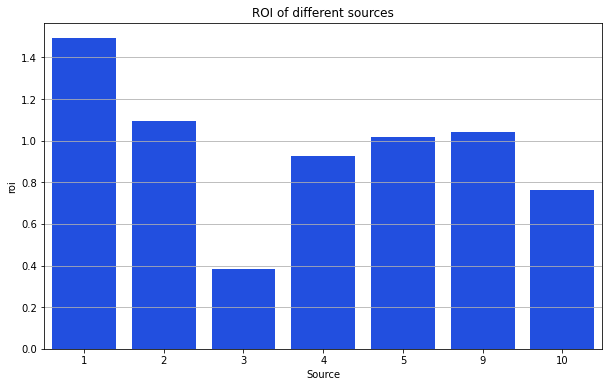

In [79]:
plt.figure(figsize = (10,6))
sns.barplot(data=ROI_by_source, x='source_id', y='roi',linewidth=1, 
            palette=sns.color_palette("bright", 1)).set(title='ROI of different sources', xlabel='Source', ylabel='roi')
plt.grid(axis='y')


#Plotting additional info
ax.set_title('ROI of different sources')
ax.set_xlabel('Source')
ax.set_ylabel('roi coefficient')
plt.show()

We can say with confidence that only 1, 2, 5, 9 sources are profitable and 1, 2 sources demonstrate the best potential for further investment. So, it would make sense to increase marketing costs in the profitable sources so as to attract more users and make profit at the same time.

## Conclusion

The task in the analytical department at Yandex.Afisha is to help optimize marketing expenses using:
- Server logs with data on Yandex.Afisha visits from June 2017 through May 2018
- Dump file with all orders for the period
- Marketing expenses statistics

**Data Preparation**

There were no missing values in the dataset, however, column names were standardized and some column data types were changed to appropriate data types.

**How many people use it every day, week, and month?**

The usage of the product by the users was analysed. 
On average, 907 people use the product daily, 5621 weekly, and 23228 monthly. 

**How many sessions are there per day?**

There are 987 sessions per day on average.

**What is the length of each session?**

Average user session is 300 sec. and the most common session duration is 60 sec.

Since the distribution is skewed to the right, it is more sensible to use the most common value (mode) to get the sense of the length of each session. It turns out, that the most common session duration is 1 min.

**What's the user retention rate?**

Product usage dos not exceed 10% after month 1. The September cohort has the highest retention rate in the first month and the second month, however, it dropped to less than 4% in just three months. The June cohort can be regarded as the most successful, since it fetures the highest retention rate over time.  

**When do people start buying?**

It takes 0 days, on average, for a user to make a purchase and the conversion rate to purchase is: 16.0%

**How many orders do users make during a given period of time?**

June cohort has the largest orders per buyer in total of all cohorts with 2.19 orders, followed by the August cohort, with 1.6 orders.

**What is the average purchase size?**
The average cheque is stable around the whole record history, with the exception of the September cohort, averaging 17 usd and December cohort with 14 usd mean value.

**How much money do they bring?**
It can be derived from the pivot_table, that there are two cohorts that performed better, than others on 6 months mark, namely June and Semtember cohorts. The June cohort saw 11.88 usd ltv per user and September cohort saw 13.44 usd ltv per user.

**How much money was spent? Overall, per source and over time**
1. Overall, 329131.62 usd was spent on marketing

2. Costs per source go as follows: 

source 1 - 	20833.27

source 2 -	42806.04

source 3 - 	141321.63

source 4 - 	61073.60

source 5 - 	51757.10

source 9 -	5517.49

source 10 -	5822.49

3. Cusomer acquisition cost over time
We can derive following conclusions from the CAC analysis:
- CAC is relatively stable across the timeline, with one major exception - august 2018. That month saw the fewest acquired users of all (1370), which led to record high CAC (10.8 USD), since the costs were not aligned accordingly. 
- The most cost effective month of all was May 2018 with just 7.4 USD CAC and respectable, slightly below average acquired user number of 2988.

**How much did customer acquisition from each of the sources cost?**

Marketing costs, CAC per source are as follows:

    source_id | Costs | CAC 
    
    1    20833.27,  7.186364

	2	42806.04, 12.209367
	3	141321.63, 13.493901
	4	61073.60, 5.931779
	5	51757.10, 7.467479
	9	5517.49, 5.071222
	10   5822.49, 4.381106
    
    
    







It can be concluded, that, on average, the most expensive sources of acquisition are 2,3, while 10, 9 are the most cost effective sources.


**How worthwhile where the investments? (ROI)**

Generally, the investments in marketing don't break even with few notable exceptions. June cohort features poor return in the first half of the year and only manages to start returning the money invested only on the 7th month, while the Semptember cohort comes on top with reaching the break evem point and exceeding it on thr 4th month.

With regards to per source ROI analysis, we can say with confidence that only 1, 2, 5, 9 sources are profitable and 1, 2 sources demonstrate the best potential for further investment. So, it would make sense to increase marketing costs in the profitable sources so as to attract more users and make profit at the same time.